### Reference

* https://github.com/zhouhaoyi/Informer2020/tree/main
* https://doheon.github.io/%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84/time-series/ci-5.informer-post/

### Import Library

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['axes.unicode_minus'] = False
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
from models.model import Informer
from utils.data_loader import *

import sys
sys.path.insert(1, "/Users/yeojisu/Documents/House-Price-Index-Prediction")
from config.config_KR import *

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Load Dataset

In [2]:
target_df = load_target_data(TARGET_PATH)
df = load_feature_data(FEATURE_PATH, FEATURE_COLUMN, TRAIN_DATE)

df = pd.concat([df,target_df],axis = 1) 
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df = df.dropna()

date = 'date'
df = df.reset_index(names=date) 
df[date] = pd.to_datetime(df[date]) 

df.reset_index(drop=True, inplace=True)
df.index.name = "num"

### Train

In [3]:
window_size  = WINDOW_SIZE
forecast_size = FORECAST_HORIZON

pred_len = forecast_size
label_len = window_size

idx = df[df[date] == pd.to_datetime(TEST_DATE)].index[0]
train_df = df[:idx]
test_df = df[idx-(forecast_size+window_size):].reset_index(drop=True)
test_df.index.name = "num"

columns_to_use = FEATURE_COLUMN + target_df.columns.tolist()

In [4]:
### Experiment Setting
batch_size = 16
epoch_ = 1000
lr = 0.00005
patience = 20  # easrly stopping

In [ ]:
# Prepare Dataset
train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, date, columns_to_use)
train_ds = Dataset_Pred(dataframe=train_df_fe ,scale=False, size = (window_size , window_size, forecast_size))
train_dl = DataLoader(train_ds,batch_size=batch_size,shuffle=False)

test_ds = Dataset_Pred(dataframe=test_df_fe ,scale=False, size = (window_size , window_size, forecast_size))
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

# Train the model 
train_loss_list = [] # save the train loss
test_loss_list = [] # save the test loss

# Define the model
model = Informer(
    enc_in = len(columns_to_use),
    dec_in = len(columns_to_use),
    c_out = len(columns_to_use),
    seq_len = window_size, # 입력 크기
    label_len = window_size, # 디코더에서 참고할 크기 
    out_len = forecast_size, # 예측할 크기 
)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
max_loss = 999999999

patience_counter = 0

  5%|▌         | 53/1000 [03:41<1:05:55,  4.18s/it]

Early stopping triggered.


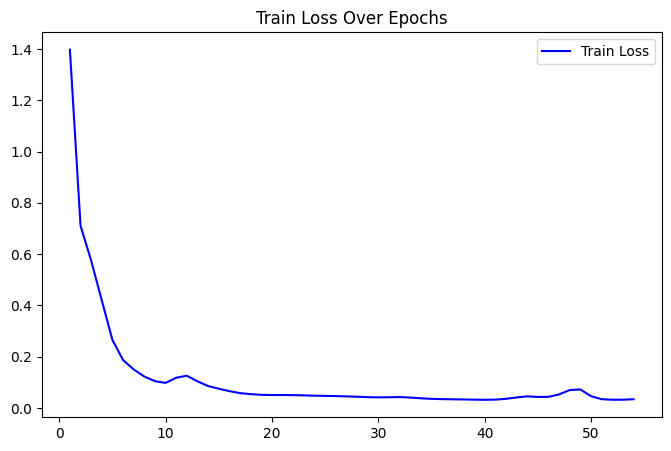

In [ ]:
dir_path = "/Users/yeojisu/Documents/HPI-Save/Korea/Baseline/recent/"
version = f"{forecast_size}month_Informer"

for epoch in tqdm(range(1, epoch_+1)):
    loss_list = []
    model.train()
    train_loss = 0.0 
    
    for i, (batch_x,batch_y,batch_x_mark,batch_y_mark) in enumerate(train_dl):
        optimizer.zero_grad()
        # batch_size = 16
        # seq_len = 3
        # pred_len = 3
        # label_len = 3
        # features = 20
        batch_x = batch_x.float()  # shape = [16, 3, 20]
        batch_y = batch_y.float() # shape = [16, 6, 20]
        batch_x_mark = batch_x_mark.float() # shape = [16, 3, 4]
        batch_y_mark = batch_y_mark.float() # shape = [16, 6, 4]
        
        dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float() # dec_inp.shape = [16, 6, 20]
        output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark)
        target = batch_y[:,-pred_len:,:]
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        
    train_loss = np.mean(loss_list) 
    train_loss_list.append(train_loss) 

    if train_loss < max_loss:
        torch.save(model.state_dict(), dir_path+f"model_{version}.pth")
        max_loss = train_loss
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Model Saved".format(train_loss, test_loss))
    else:
        patience_counter += 1
        # print("Train_loss={:.3f}, Test_loss={:.3f}, Patience: {}/{}".format(train_loss, test_loss, patience_counter, patience))
    
    if patience_counter >= patience:
        print("Early stopping triggered.")
        break
    
plt.figure(figsize=(8, 5))
epochs = range(1, len(train_loss_list) + 1)
plt.plot(epochs, train_loss_list, label='Train Loss', color='b')
plt.legend()
plt.title('Train Loss Over Epochs')
plt.show()

### Forecast

/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_1236/3481014827.py:51: FutureWarning: 'm' is deprecated and will be removed in a future version, please use 'ME' instead.
  pred_dates = pd.date_range(tmp_stamp.date.values[-1], periods=self.pred_len+1, freq=self.freq)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_1236/3481014827.py:5: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['month'] = dates.date.apply(lambda row:row.month,1)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_1236/3481014827.py:6: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates['day'] = dates.date.apply(lambda row:row.day,1)
/var/folders/pc/0_qqcqxd1fncd71rzs72fhr00000gn/T/ipykernel_1236/3481014827.py:7: FutureW

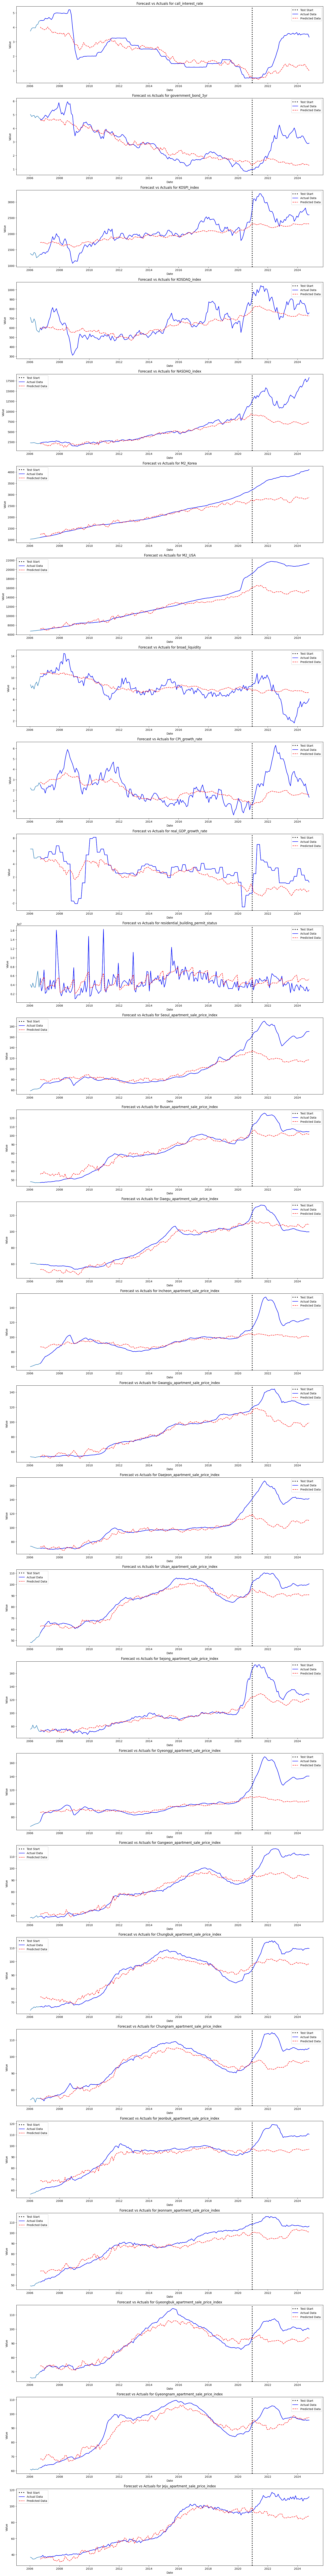

In [ ]:
# Load model and Evaluate
model.load_state_dict(torch.load(dir_path+f"model_{version}.pth"))  # 최적 모델 로드
model.eval()

train_ds = Dataset_Pred(dataframe=train_df_fe ,scale=False, size = (window_size , window_size, forecast_size))
train_dl = DataLoader(train_ds,batch_size=len(train_df),shuffle=False)

test_ds = Dataset_Pred(dataframe=test_df_fe ,scale=False, size = (window_size , window_size, forecast_size))
test_dl  = DataLoader(test_ds,  batch_size = len(test_df), shuffle=False)

with torch.no_grad():
    for batch_x,batch_y,batch_x_mark,batch_y_mark in train_dl:
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float() # dec_inp.shape = [16, 6, 20]
        output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark) # shape = [172, 3, 20]
        target = batch_y[:,-pred_len:,:] # shape = [172, 3, 20]
        
        train_predicted = output[:,-1,:].cpu().numpy()
        train_actual = target[:,-1,:].cpu().numpy()
    
    for batch_x,batch_y,batch_x_mark,batch_y_mark in test_dl:
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        batch_x_mark = batch_x_mark.float()
        batch_y_mark = batch_y_mark.float()
        dec_inp = torch.zeros([batch_y.shape[0], pred_len, batch_y.shape[-1]]).float()
        dec_inp = torch.cat([batch_y[:,:label_len,:], dec_inp], dim=1).float() # dec_inp.shape = [16, 6, 20]
        output = model(batch_x, batch_x_mark, dec_inp, batch_y_mark) # shape = [172, 3, 20]
        target = batch_y[:,-pred_len:,:] # shape = [172, 3, 20]
        
        test_predicted = output[:,-1,:].cpu().numpy()
        test_actual = target[:,-1,:].cpu().numpy()
        
train_dates = train_df.date[window_size+forecast_size-1:]
test_dates = test_df.date[window_size+forecast_size-1:]
test_dates = test_dates.reset_index(drop=True)    
plt.figure(figsize=(20, len(columns_to_use) * 6))  # Adjust the figure size as needed
for i in range(len(columns_to_use)):
    idv_mean = mean_[columns_to_use[i]]
    idv_std = std_[columns_to_use[i]]
    plt.subplot(len(columns_to_use), 1, i + 1)
    plt.plot(df[date], df[columns_to_use[i]])
    plt.plot(train_dates, train_actual[:, i]*idv_std+idv_mean, c="b")
    plt.plot(train_dates, train_predicted[:, i]*idv_std+idv_mean, linestyle='--', c="r")
    plt.axvline(x=test_dates[0], color='black', linestyle=':', linewidth=3,label="Test Start")
    plt.plot(test_dates, test_actual[:, i]*idv_std+idv_mean, label='Actual Data', c="b")
    plt.plot(test_dates, test_predicted[:, i]*idv_std+idv_mean, label='Predicted Data', linestyle='--', c="r")
    plt.title(f'Forecast vs Actuals for {columns_to_use[i]}')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()        
    real = test_actual[:, i]*idv_std+idv_mean
    pred = test_predicted[:, i]*idv_std+idv_mean
    
    rmse = round(mean_squared_error(real, pred)**0.5,3)
    mae = round(mean_absolute_error(real, pred),3)
    
    if columns_to_use[i] in target_df.columns:
        val = [columns_to_use[i].split("_")[0], rmse, mae]
        pd.DataFrame(val).T.to_csv(dir_path+f"result_{version}.csv", mode='a', header=False, index=False)
